# Autoencoder

## Imports
1. Wir importieren `numpy`, um unsere Daten als `np.array` zu repräsentieren.
2. `tensorflow` ist ein open-source machine learning Framework. Mit `keras`, einer high-level API, können wir auf TensorFlow zugreifen.
3. Mit `matplotlib` können wir Graphen erzeugen und Bilder ausgeben.

In [1]:
import numpy as np

from tensorflow import config
from tensorflow import keras
from keras import layers
from keras.models import Model
from keras.datasets import mnist

import matplotlib.pyplot as plt

## (Optional) GPU Beschleunigung
Ohne GPU Beschleunigung braucht das trainieren der Modelle länger, da sie sonst auf der CPU laufen.

Damit wir GPU Beschleunigung nutzen können muss:
1. Eine Nvidia GPU verfügbar sein
2. Folge disem [Link](https://www.tensorflow.org/install/pip?_gl=1*1gkcx8r*_ga*NzMyODIwOTcwLjE2ODQ2OTUzOTE.*_ga_W0YLR4190T*MTY4NDY5NTM5MS4xLjEuMTY4NDY5NTcyMS4wLjAuMA..#windows-%5Bwsl2%5D) und erstelle ein environment mit Anaconda
3. Führe folgende Befehle mit Anaconda aus:
    1. `conda install -c conda-forge notebook`
    2. `conda activate <environment_name>` ('tf' im Tutorial)
    3. `jupyter notebook`

In [2]:
# Prüfe ob GPU Beschleunigung aktiv ist
print(config.list_physical_devices('GPU'))

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Einfacher Autoencoder

Ein Autoencoder erlernt mittels *unsupervised learning* Daten in einen niedrigdimensionalen Raum abzubilden. Das Ziel besteht darin, eine effiziente Datenrepräsentation mit minimalem Datenverlust zu erreichen.  

Der Autoencoder besteht aus zwei Teilen: dem *Encoder*, der die Daten in eine niedrigdimensionale Darstellung kodiert, und dem *Decoder*, der die Daten von dieser komprimierten Repräsentation wieder in ihre ursprüngliche Dimension zurückführt.

#### Datenset

Als Datenset laden wir die [MNIST-Datenbank](https://de.wikipedia.org/wiki/MNIST-Datenbank). Sie umfasst 70.000 handgeschriebene Ziffern. Diese sind in 60.000 Trainingsdaten und 10.000 Testdaten unterteilt, die wir als `x_train` und `x_test` laden.

In [3]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

Zur Veranschaulichung können wir ein paar Bilder aus dem Datenset zeigen.

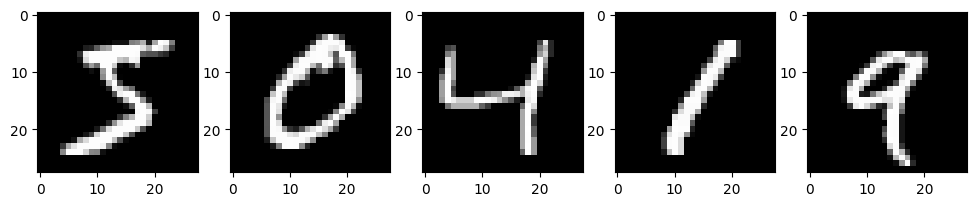

In [4]:
# Display some examples
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

for i in range(5):
    axes[i].imshow(x_train[i], cmap='gray')

plt.show()

Jedes Bild ist ein 28x28 großes Graustufenbild. Diese können wir normalisieren indem wir jeden Pixel durch 255 teilen. Anschließend wandeln wir jedes Bild in einem 1-dimensionalen Vektor um. Jedes Bild besteht nun also aus 784 Datenpunkten.

In [5]:
# Normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Make data 1-dimensional
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#### Encoder

Der Encoder nimmt Eingangsdaten entgegen und wendet eine Reihe von mathematischen Operationen an. Dabei wird die Dimensionalität der Daten reduziert, indem die wesentlichen Informationen erfasst und weniger relevante oder rauschhafte Details verworfen werden. Das Ziel besteht darin, eine kompakte und sinnvolle Darstellung der Eingangsdaten in einem niedrigdimensionalen Raum zu erzeugen, der auch *Latent Space* oder *Bottleneck* genannt wird.

Um das Neuronale Netz des Encoders zu bauen, definieren wir zunächst die *Input Layer*. Diese gleicht in ihrer Dimensionalität unseren Eingangsdaten. 

In [6]:
# Define input layer
input_shape = (784,)  # 28x28 pixels for MNIST digits
input_layer = layers.Input(shape=input_shape)

Anschließen fügen wir dem Netz mehrere *Hidden Layers* hinzu. Diese werden zuhnehmend kleiner, wodurch die Daten weiter komprimiert werden. Die letze Schicht des Encoders ist die Ausgansebene oder auch *Output Layer*. Diese definiert somit die Dimensionalität auf die wir unsere Daten abbilden.

In [7]:
# Define encoder architecture
encoder = layers.Dense(256, activation='relu')(input_layer)
encoder = layers.Dense(128, activation='relu')(encoder)
encoder = layers.Dense(64, activation='relu')(encoder)

#### Decoder

Der Decoder nimmt die komprimierte Darstellung der Daten aus dem Encoder, die im *latenten Raum* oder *Bottleneck* liegt, entgegen. Der Decoder wendet daraufhin eine Reihe von mathematischen Operationen an, um die Daten wieder in ihre ursprüngliche Dimensionalität zu überführen. Das Ziel besteht darin, eine möglichst genaue Rekonstruktion der originalen Eingangsdaten zu erzeugen.

Um das neuronale Netz des Decoders zu bauen, erstellen wir eine *Input Layer*, die die Daten aus dem Encoder entgegen nimmt. Anschließend erhöhen wir die Dimensionalität der Daten über *Hidden Layers* bis sie in der *Output Layer* wieder die ursprüngliche Dimensionalität angenommen haben.

In [8]:
# Define decoder architecture
decoder = layers.Dense(128, activation='relu')(encoder)
decoder = layers.Dense(256, activation='relu')(decoder)
decoder = layers.Dense(input_shape[0], activation='sigmoid')(decoder)

Da wir nun Encoder als auch Decoder definiert haben, können wir jetzt das ganze Modell des Autoencoders erstellen.

In [9]:
# Define autoencoder model
autoencoder = Model(input_layer, decoder)

#### Training

Damit das Modell lernt die Daten möglichst effizient zu komprimieren, müssen wir es trainieren. Dabei werden iterativ Daten verarbeitet, die Ergebnisse bewertet, und das Netz angepasst.

Zunächst müssen wir den Autoencoder kompilieren. Dazu geben wir einen Optimierungsalgorithmus an, welcher die Gewichte im Model verändert um zu lernen. Zuletzt bestimmen wir eine Verlustfunktion, die die Ähnlichkeit zwischen dem ursprünglichem Input und dem rekonstruierten Output vergleicht.

In [10]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Nun trainieren wir das Model. Hierbei sind `x_train` sowohl unsere Eingangsdaten als auch unsere Ausgangsdaten, da der Decoder sie rekonstruieren soll. Die Anzahl der `epochs` bestimmt wie häufig das ganze Dataset durchlaufen wird. Die `batch_size` gibt an wie viele Datenexemplare dabei gleichzeitig durch das Netz propagieren bevor die Gewichte angepasst werden.

In [11]:
# train the model
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 2s 1ms/step - loss: 0.1757
Epoch 2/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1096
Epoch 3/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0979
Epoch 4/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0920
Epoch 5/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0886
Epoch 6/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0860
Epoch 7/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0842
Epoch 8/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0825
Epoch 9/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0812
Epoch 10/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0802


Beim Trainieren des Models weren mehrere Schritte durchlaufen:
1. ***Forward Pass:*** Die Eingabedaten werden in den Autoencoder eingespeist und durchlaufen eine Vorwärtspropagation sowohl durch den Encoder als auch den Decoder.

2. **Verlustberechnung:** Mithilfe der Verlustfunktion wird die Diskrepanz zwischen Eingabedaten und rekonstruierten Daten quantifiziert.

3. ***Backward Pass:*** Die Gradienten des Verlusts bezüglich der Parameter des Autoencoders werden durch Rückwärtspropagation berechnet. Diese Gradienten geben die Richtung und Größe der Parameteraktualisierungen an, die erforderlich sind, um den Verlust zu minimieren.

4. **Aktuallisierung der Parameter:** Der Optimierungsalgorithmus verwendet die Gradienten, um die Parameter des Autoencoders zu aktualisieren.

Nach dem Training kann der Autoencoder für verschiedene Aufgaben benutzt werden. Um unser trainiertes Modell zu evaluieren, wenden wir es auf unsere Testdaten an. Wir kodieren also zunächst die Trainingsdaten, wodurch eine Dimensionalitätsreduktion stattfindet. Dann dekodieren wir diese Daten um die ursprünglichen daten zu rekonstruieren.

In [12]:
# Encode and decode some digits
encoded_imgs = autoencoder.predict(x_test)
decoded_imgs = autoencoder.predict(encoded_imgs)

313/313 [==============================] - 0s 568us/step


Nun können wir einen Graphen erstellen der die Testdaten mit den Daten aus dem Decoder vergleicht.

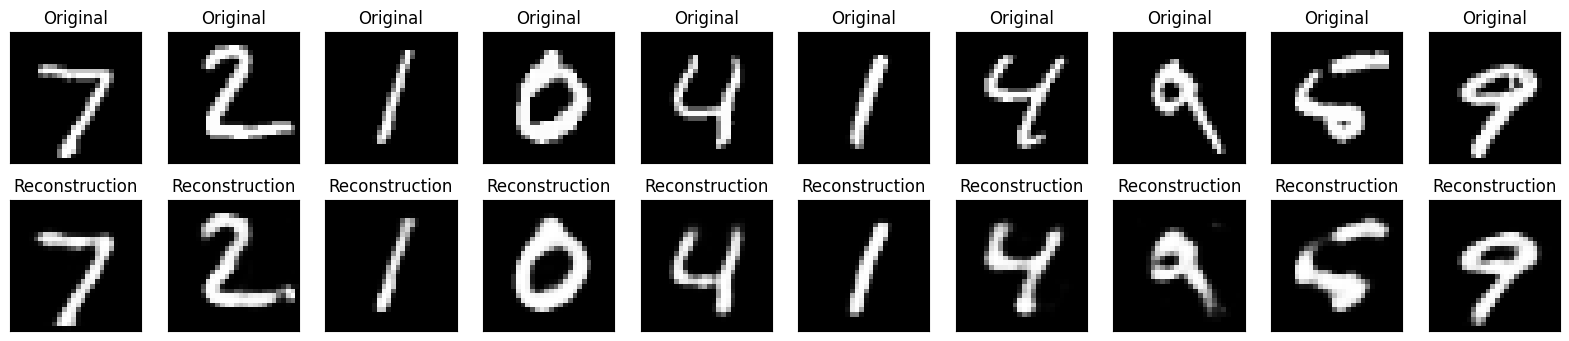

In [13]:
n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Original')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Reconstruction')
plt.show()

Der Datenverlust sollte nach dem Training bei etwa 8% liegen. Daher lassen sich auch Unterschiede in den Bildern erkennen. Das bemerkenswerte ist jedoch, dass wir die Informationen für jedes Bild von 784 floats auf lediglich 64 reduziert haben. Das heißt wir können mit nur 8% an Informationen die Daten zu 92% genau rekonstruieren!  

Wenn man sich die Bilder genauer anguckt, fällt auf das besonders Eigenschaften die etwas ungewöhnlicher sind, wie der Strich im Ring der 9, weitaus weniger in der Rekonstruktion ausgeprägt sind. Dem Modell ist es also gelungen bestimmte Muster zu erkennen und die Daten darauf zu reduzieren.

## Denoising Autoencoder
Während ein standard Autoencoder lernt Daten basiert auf den Eingangsdaten zu rekonstruieren, lernt ein Denoising Autoencoder klare Daten aus verrauschten Daten wiederherzustellen.

Dazu fügen wir künstliches Rauschen auf unsere Trainingsdaten hinzu.

In [14]:
# Add artificial gaussian noise to training data
def noise_dataset(dataset, noise_factor=0.5):
    dataset = dataset + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dataset.shape)
    dataset = np.clip(dataset, 0.0, 1.0)
    return dataset

x_train_noisy = noise_dataset(x_train)

Nun geben wir dem Model die verauschten Daten als Eingabedaten und die orignalen Daten als Zieldaten. Dadurch lernt das Model effektiv das Rauschen zu entfernen.

In [15]:
# Train the autoencoder
autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1273
Epoch 2/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1149
Epoch 3/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1126
Epoch 4/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1110
Epoch 5/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1098
Epoch 6/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1089
Epoch 7/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1080
Epoch 8/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1075
Epoch 9/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1069
Epoch 10/10
469/469 [==============================] - 1s 1ms/step - loss: 0.1064


Um unser Model anzuwenden benötigen wir verrauschte Eingangsdaten. Dazu fügen wir unseren Testdaten Rauschen hinzu. Danach können wir unser trainiertes Netz anwenden, und erhalten ein entrauschten Testdatensatz.

In [16]:
# Apply denoising to test data
x_test_noisy = noise_dataset(x_test)
x_test_denoised = autoencoder.predict(x_test_noisy)

313/313 [==============================] - 0s 661us/step


Die entrauschten Bilder können wir nun zusammen mit den Original- und verrauschten Bildern anzeigen lassen.

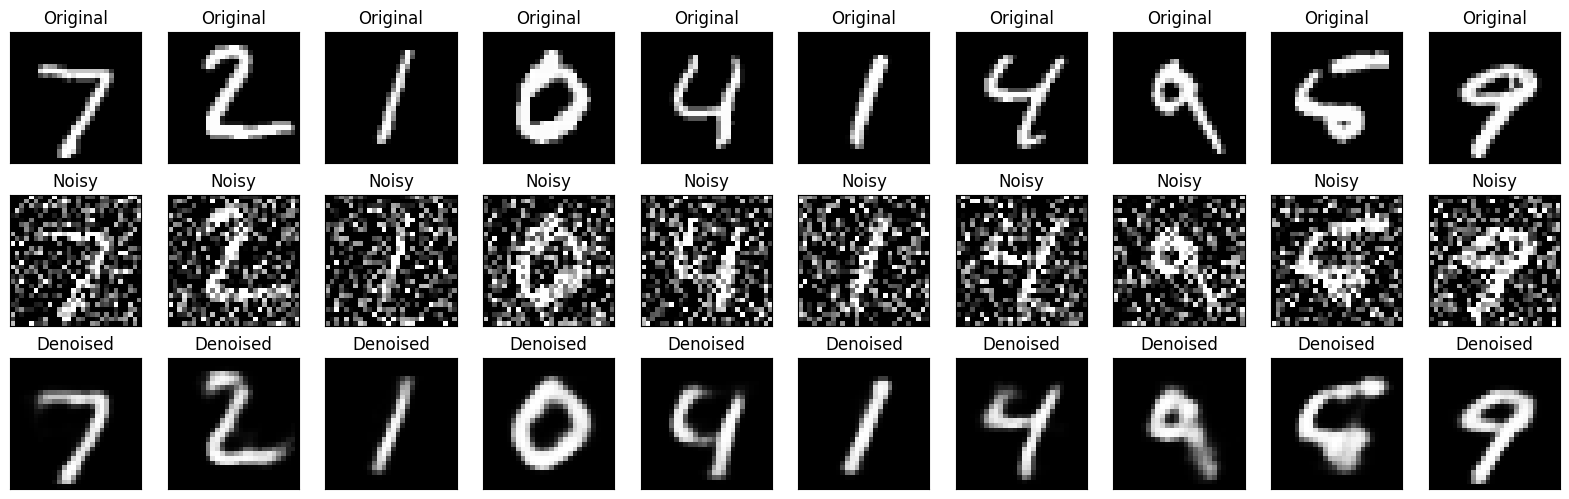

In [17]:
def show_denoising_results(img_shape, original_dataset, noisy_dataset, denoised_dataset):
    "Display the original, noisy, and denoised images"
    n = 10  # Number of images to display
    plt.figure(figsize=(20, 6))

    def create_subplot(col, row, dataset, title):
        # Original image
        ax = plt.subplot(3, col, row)
        plt.imshow(dataset[i].reshape(img_shape))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(title)

    for i in range(n):
        create_subplot(n, i + 1, original_dataset, 'Original')
        create_subplot(n, i + 1 + n, noisy_dataset, 'Noisy')
        create_subplot(n, i + 1 + 2 * n, denoised_dataset, 'Denoised')

    plt.show()

show_denoising_results((28, 28), x_test, x_test_noisy, x_test_denoised)

Nach dem Training sollte die Verlustfunktion bei etwa 9,5% liegen. Dies ist erstaunlich, da durch das Rauschen Daten verloren gehen. Außerdem ist die Rekonstruktion, wie beispielsweise beim dritten Bild, gar nicht so einfach für Menschen. Trotzdem gelingt es dem Neuronalen Netz bestimmte Muster zu erkennen, wodurch gewisse Features stärker ausgeprägt sind. So wirken die Linien kontinuierlicher und weicher. Erneut lässt sich an der letzen 9 erkennen, dass der Strich im Inneren verloren geht.